# Part 3 - RNN and LSTM

## Import libraries

In [942]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from torch.utils.data import DataLoader

from src import *

## Create dataloader

In [943]:
dataloader = CSVDataLoader('data/MSFT_2006-01-01_to_2018-01-01.csv')
X_train_1, X_test_1 = dataloader.split_by_year([2006, 2007], [2008])

training_dataset_1 = StockTorchTransDataset(X_train_1, zscore_params=None, history=5)
testing_dataset_1 = StockTorchTransDataset(X_test_1, zscore_params=training_dataset_1.get_zscore_params(), history=5)

training_loader_1 = DataLoader(training_dataset_1, batch_size=1, shuffle=False, drop_last=False)
testing_loader_1 = DataLoader(testing_dataset_1, batch_size=1, shuffle=False, drop_last=False)

for sample in training_loader_1:
    X, y = sample
    print("X:")
    print(X)
    print("y:")
    print(y)
    print("Shapes:")
    print(X.shape, y.shape)
    break

X:
tensor([[[-4.8095e-02, -4.6030e-02, -5.3258e-02,  4.0451e-01, -4.4084e-02,
           0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 1.2529e+00,  1.5959e-01,  1.8483e+00, -1.8438e-01,  2.8433e-01,
           0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,
           1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 4.2727e-01,  8.2483e-02,  3.4408e-01, -4.4480e-01,  6.4427e-03,
           0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
           1.0000e+00, 

# Transformer

In [944]:
import torch
import math

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [945]:
class MultiHeadAttention(torch.nn.Module):
    def __init__(self, D, H):
        super(MultiHeadAttention, self).__init__()
        self.H = H # number of heads
        self.D = D # dimension
        
        self.wq = torch.nn.Linear(D, D*H)
        self.wk = torch.nn.Linear(D, D*H)
        self.wv = torch.nn.Linear(D, D*H)

        self.dense = torch.nn.Linear(D*H, D)

    def concat_heads(self, x):
        '''(B, H, S, D) => (B, S, D*H)'''
        B, H, S, D = x.shape
        x = x.permute((0, 2, 1, 3)).contiguous()  # (B, S, H, D)
        x = x.reshape((B, S, H*D))   # (B, S, D*H)
        return x

    def split_heads(self, x):
        '''(B, S, D*H) => (B, H, S, D)'''
        B, S, D_H = x.shape
        x = x.reshape(B, S, self.H, self.D)    # (B, S, H, D)
        x = x.permute((0, 2, 1, 3))  # (B, H, S, D)
        return x

    def forward(self, x, mask):

        q = self.wq(x)  # (B, S, D*H)
        k = self.wk(x)  # (B, S, D*H)
        v = self.wv(x)  # (B, S, D*H)

        q = self.split_heads(q)  # (B, H, S, D)
        k = self.split_heads(k)  # (B, H, S, D)
        v = self.split_heads(v)  # (B, H, S, D)

        attention_scores = torch.matmul(q, k.transpose(-1, -2)) #(B,H,S,S)
        attention_scores = attention_scores / math.sqrt(self.D)

        # add the mask to the scaled tensor.
        if mask is not None:
            attention_scores += (mask * -1e9)
        
        attention_weights = torch.nn.Softmax(dim=-1)(attention_scores)
        scaled_attention = torch.matmul(attention_weights, v)  # (B, H, S, D)
        concat_attention = self.concat_heads(scaled_attention) # (B, S, D*H)
        output = self.dense(concat_attention)  # (B, S, D)

        return output, attention_weights

In [946]:
# Positional encodings
class PositionalEncoding(torch.nn.Module):
    """Standard sinusoidal positional encoding."""

    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2, dtype=torch.float32)
            * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)  # even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # odd indices

        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        # register_buffer -> not a parameter, but moves with .to(device)
        self.register_buffer("pe", pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, S, D_model)
        """
        S = x.size(1)
        return x + self.pe[:, :S, :]


# # function that implement the look_ahead mask for masking future time steps. 
# def create_look_ahead_mask(size, device=device):
#     mask = torch.ones((size, size), device=device)
#     mask = torch.triu(mask, diagonal=1)
#     return mask  # (size, size)

# create_look_ahead_mask(6)

class TransformerLayer(torch.nn.Module):
    def __init__(self, D, H, hidden_mlp_dim, dropout_rate):
        super(TransformerLayer, self).__init__()
        self.dropout_rate = dropout_rate
        self.mha = MultiHeadAttention(D, H)
        self.ffn = torch.nn.Sequential(
            torch.nn.Linear(D, hidden_mlp_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_mlp_dim, D),
        )
        self.layernorm1 = torch.nn.LayerNorm(D, eps=1e-9)
        self.layernorm2 = torch.nn.LayerNorm(D, eps=1e-9)
        self.dropout1 = torch.nn.Dropout(dropout_rate)
        self.dropout2 = torch.nn.Dropout(dropout_rate)



    def forward(self, x, look_ahead_mask):
        
        # Self-attention + residual + layer norm
        attn_output, attn_weights = self.mha(x, look_ahead_mask)       # (B, S, D_model)
        x = self.layernorm1(x + self.dropout1(attn_output))      # (B, S, D_model)

        # Feed-forward + residual + layer norm
        ffn_output = self.ffn(x)                            # (B, S, D_model)
        x = self.layernorm2(x + self.dropout2(ffn_output))       # (B, S, D_model)

        return x, attn_weights

In [947]:
class StockTransformer(torch.nn.Module):
    """
    Transformer encoder for stock forecasting using StockTorchTransDataset.

    Input:
        x: (B, S, F_all)
           S = history + 1, F_all = standardized price features + other features

    Output:
        y_hat: (B, num_horizons, target_dim)
           num_horizons = len(target_days) (e.g. [1] or [1, 5])
           target_dim   = 5 (first 5 standardized price-type columns)
    """

    def __init__(
        self,
        inp_features: int,
        D: int,
        H: int,
        num_layers: int,
        num_horizons: int,
        target_dim: int = 5,
        dim_feedforward: int = 128,
        dropout: float = 0.1,
        max_seq_len: int = 64,
    ):
        super().__init__()
        self.D = D
        self.num_horizons = num_horizons
        self.target_dim = target_dim

        # Project input features to model dimension
        self.input_projection = torch.nn.Linear(inp_features, D)
        self.pos_encoding = PositionalEncoding(D, max_len=max_seq_len)
        self.dropout = torch.nn.Dropout(dropout)

        # Stack of encoder layers
        self.layers = torch.nn.ModuleList(
            [TransformerLayer(D=D,H=H,hidden_mlp_dim=dim_feedforward,dropout_rate=dropout) for _ in range(num_layers)]
        )

        # Final prediction head: from last time step representation
        # to all horizons × target_dim
        self.output_projection = torch.nn.Linear(D, num_horizons * target_dim)

    def forward(self, x, mask = None):
        """
        x: (B, S, inp_features) coming directly from StockTorchTransDataset
        returns:
            preds: (B, num_horizons, target_dim)
            attn_weights_all: list of attention maps from each layer
        """
        B, S, F = x.shape

        # Input projection + positional encoding
        x = self.input_projection(x) * math.sqrt(self.D)
        x = self.pos_encoding(x)
        x = self.dropout(x)

        attn_weights_all = []
        for layer in self.layers:
            x, attn_w = layer(x, mask)
            attn_weights_all.append(attn_w)

        # Use representation of the last time step # Something like CLS token
        last_hidden = x[:, -1, :]  # (B, D)

        out = self.output_projection(last_hidden)
        out = out.view(B, self.num_horizons, self.target_dim)

        return out, attn_weights_all

In [948]:
def build_dataloaders(
    csv_path: str,
    train_years,
    test_years,
    history: int = 5,
    target_days = [1],
    batch_size: int = 32,
):
    """
    Helper to create train/test DataLoaders for StockTorchTransDataset.
    Adjust `csv_path` and years according to your setup.
    """
    csv_loader = CSVDataLoader(csv_path)
    csv_loader.load()  # load into memory

    X_train, X_test = csv_loader.split_by_year(train_years, test_years)

    train_ds = StockTorchTransDataset(
        X_train,
        zscore_params=None,
        history=history,
        target_days=target_days,
    )
    test_ds = StockTorchTransDataset(
        X_test,
        zscore_params=train_ds.get_zscore_params(),
        history=history,
        target_days=target_days,
    )

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, train_ds

In [949]:
def train_one_epoch(
    model: torch.nn.Module,
    loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    device: torch.device,
):
    model.train()
    total_loss = 0.0
    n_samples = 0

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        preds, _ = model(x)
        loss = loss_fn(preds, y)
        loss.backward()
        optimizer.step()

        batch_size = x.size(0)
        total_loss += loss.item() * batch_size
        n_samples += batch_size

    return total_loss / max(n_samples, 1)

@torch.no_grad()
def evaluate(
    model: torch.nn.Module,
    loader: DataLoader,
    loss_fn: torch.nn.Module,
    device: torch.device,
):
    model.eval()
    total_loss = 0.0
    n_samples = 0

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        preds, _ = model(x)
        loss = loss_fn(preds, y)

        batch_size = x.size(0)
        total_loss += loss.item() * batch_size
        n_samples += batch_size

    return total_loss / max(n_samples, 1)

In [950]:
if __name__ == "__main__":
    # Example configuration – adjust to your paths and years
    csv_path = 'data/MSFT_2006-01-01_to_2018-01-01.csv'
    train_years = list(range(2006, 2008))   # example: 2006–2016
    test_years = [2009]               # example: 2017–2018
    history = 10
    target_days = [1, 5]                       # predict 1 day ahead
    batch_size = 32

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_loader, test_loader, train_ds = build_dataloaders(
        csv_path=csv_path,
        train_years=train_years,
        test_years=test_years,
        history=history,
        target_days=target_days,
        batch_size=batch_size,
    )

    # Model hyperparameters
    inp_features = train_ds.F_all          # number of input features from StockTorchTransDataset
    num_horizons = len(target_days)        # number of days ahead we predict
    d_model = 32
    num_heads = 4
    num_layers = 2
    dim_feedforward = 64
    dropout = 0.1

    model = StockTransformer(
        inp_features=inp_features,
        D=d_model,
        H=num_heads,
        num_layers=num_layers,
        num_horizons=num_horizons,
        target_dim=5,
        dim_feedforward=dim_feedforward,
        dropout=dropout,
        max_seq_len=history + 1,
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    loss_fn = torch.nn.MSELoss()

    n_epochs = 30
    for epoch in range(1, n_epochs + 1):
        train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
        test_loss = evaluate(model, test_loader, loss_fn, device)
        print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} | test_loss={test_loss:.4f}")


Epoch 01 | train_loss=1.4071 | test_loss=1.3664
Epoch 02 | train_loss=1.2933 | test_loss=1.2749
Epoch 03 | train_loss=1.2353 | test_loss=1.2211
Epoch 04 | train_loss=1.1989 | test_loss=1.1864
Epoch 05 | train_loss=1.1557 | test_loss=1.1610
Epoch 06 | train_loss=1.1228 | test_loss=1.1433
Epoch 07 | train_loss=1.1052 | test_loss=1.1296
Epoch 08 | train_loss=1.0845 | test_loss=1.1187
Epoch 09 | train_loss=1.0646 | test_loss=1.1108
Epoch 10 | train_loss=1.0513 | test_loss=1.1047
Epoch 11 | train_loss=1.0405 | test_loss=1.0991
Epoch 12 | train_loss=1.0375 | test_loss=1.0951
Epoch 13 | train_loss=1.0238 | test_loss=1.0919
Epoch 14 | train_loss=1.0254 | test_loss=1.0891
Epoch 15 | train_loss=1.0166 | test_loss=1.0865
Epoch 16 | train_loss=1.0142 | test_loss=1.0838
Epoch 17 | train_loss=1.0064 | test_loss=1.0813
Epoch 18 | train_loss=1.0002 | test_loss=1.0790
Epoch 19 | train_loss=0.9960 | test_loss=1.0775
Epoch 20 | train_loss=0.9937 | test_loss=1.0762
Epoch 21 | train_loss=0.9845 | test_loss

## Evaluating

In [951]:
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)

        out = model(x)
        if isinstance(out, tuple):
            out = out[0]

        all_preds.append(out.cpu())
        all_targets.append(y.cpu())

preds = torch.cat(all_preds, dim=0).numpy()    # (N, 1, 5)
targets = torch.cat(all_targets, dim=0).numpy()


Compute the MAE of the predicted close prices. If the model is trained to predict both tomorrow’s value and some value further in the future, the final accuracy increases significantly:)

In [952]:
def compute_mae_first_close(preds_close, targets_close, train_ds, horiz_index=0):
    # z-score parametres
    mu, sigma = train_ds.get_zscore_params()
    mu_close, sigma_close = mu[4], sigma[4]

    # original space
    preds_inv = preds_close * sigma_close + mu_close
    targets_inv = targets_close * sigma_close + mu_close

    # MAE
    mae = np.mean(np.abs(preds_inv - targets_inv))
    return mae

horiz_index = 0
preds_close = preds[:,horiz_index,4]
targets_close = targets[:,horiz_index,4]
print(f"Test MAE = {compute_mae_first_close(preds_close, targets_close, train_ds, horiz_index)}")

Test MAE = 0.3385665714740753


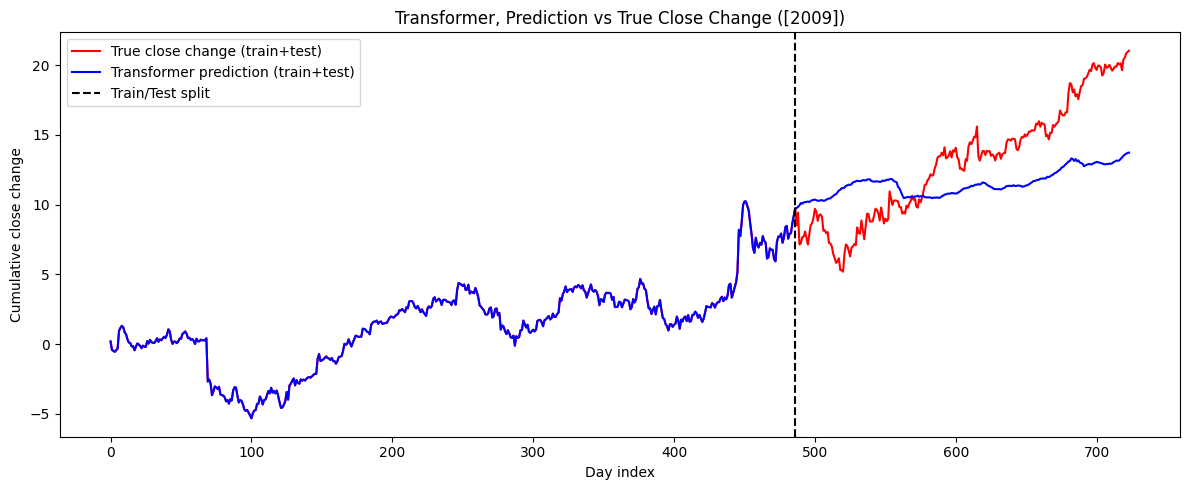

In [953]:
mu, sigma = train_ds.get_zscore_params()
mu_close, sigma_close = mu[4], sigma[4]
preds_inv = np.array(preds_close) * sigma_close + mu_close
train_targets = []
for _, y in DataLoader(train_ds, batch_size=1, shuffle=False):
    # print(y)
    train_targets.append(y[:,horiz_index,4].squeeze(0).item())
    # break
train_targets = np.array(train_targets)
train_targets_inv = train_targets * sigma_close + mu_close

# print(train_targets_inv.shape, preds_inv.shape)

full_pred = np.concatenate([train_targets_inv, preds_inv.ravel()])
full_true = np.concatenate([train_targets_inv, np.array(targets_close.ravel()) * sigma_close + mu_close])

full_pred_curve = np.cumsum(full_pred)
full_true_curve = np.cumsum(full_true)

plt.figure(figsize=(12,5))
plt.plot(full_true_curve, c="r", label="True close change (train+test)")
plt.plot(full_pred_curve, c="b", label="Transformer prediction (train+test)")
plt.axvline(len(train_targets_inv)-1, color='k', linestyle='--', label='Train/Test split')
plt.title(f"Transformer, Prediction vs True Close Change ({test_years})")
plt.xlabel("Day index")
plt.ylabel("Cumulative close change")
plt.legend()
plt.tight_layout()
plt.show()